In [1]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import glob

class NYUDepthH5(Dataset):
    def __init__(self, h5_files, target_size=(320,240), transform=None):
        """
        h5_files : list of .h5 file paths (from train/val .tar extracts)
        target_size : (W, H) resize for network
        """
        self.h5_files = h5_files
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.h5_files)

    def __getitem__(self, idx):
        with h5py.File(self.h5_files[idx], "r") as f:
            rgb = np.array(f["rgb"])       
            depth = np.array(f["depth"])  

        # Convert RGB to HWC
        rgb = np.transpose(rgb, (1, 2, 0)).astype(np.uint8)

        # resize
        rgb = cv2.resize(rgb, self.target_size)
        depth = cv2.resize(depth, self.target_size, interpolation=cv2.INTER_NEAREST)

        # normalize RGB (ImageNet)
        rgb = rgb / 255.0
        rgb = (rgb - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])
        rgb = torch.from_numpy(rgb.transpose(2,0,1)).float()

        # normalize depth
        depth = np.clip(depth, 0.1, 10.0).astype(np.float32)  
        depth = torch.from_numpy(depth).unsqueeze(0)        

        return rgb, depth


In [2]:
train_files = glob.glob("/kaggle/input/nyu-depth-v2/train/**/*.h5", recursive=True)
val_files   = glob.glob("/kaggle/input/nyu-depth-v2/val/**/*.h5", recursive=True)

train_dataset = NYUDepthH5(train_files)
val_dataset   = NYUDepthH5(val_files)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

# ---------------------------
# Pixel Shuffle Upsample Block
# ---------------------------
class PixelShuffleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2, n_bottlenecks=2):
        super().__init__()
        # conv to expand channels for pixel shuffle
        self.expand = nn.Conv2d(in_channels, out_channels * (upscale_factor**2), kernel_size=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
        self.bottlenecks = nn.Sequential(*[
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for _ in range(n_bottlenecks)
        ])
        self.out_conv = nn.Conv2d(out_channels, 1, kernel_size=1)  # depth map

    def forward(self, x):
        x = self.expand(x)          
        x = self.pixel_shuffle(x)   
        x = self.bottlenecks(x)
        depth = self.out_conv(x)
        return depth, x

        

# ---------------------------
# Full Network
# ---------------------------
class DepthNet(nn.Module):
    def __init__(self, width_mult=1.0, pretrained=False):
        super().__init__()
        
        if width_mult == 1.0 and pretrained:
            mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        else:
            mobilenet = models.mobilenet_v2(width_mult=width_mult, weights=None)
        
        self.encoder = mobilenet.features
        self.skip_ids = [2, 4, 7, 14]

        # figure out encoder output channels dynamically
        self.enc_out_channels = mobilenet.last_channel   # 1280 if width_mult=1.0, 320 if 0.35, etc.

        # decoder blocks
        self.dec1 = PixelShuffleBlock(self.enc_out_channels, 512, upscale_factor=2)
        self.dec2 = PixelShuffleBlock(512, 256, upscale_factor=2)
        self.dec3 = PixelShuffleBlock(256, 128, upscale_factor=2)
        self.dec4 = PixelShuffleBlock(128, 64, upscale_factor=2)


    def forward(self, x):
        # ---------------- Encoder ----------------
        features = []
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if i in self.skip_ids:
                features.append(x)
        bottleneck = x  # deepest feature

        # ---------------- Decoder ----------------
        d1, f1 = self.dec1(bottleneck)
        d2, f2 = self.dec2(f1)
        d3, f3 = self.dec3(f2)
        d4, f4 = self.dec4(f3)

        # upsample all depth outputs to match input size
        depth_outs = [nn.functional.interpolate(d, size=(240,320), mode="bilinear", align_corners=True)
                      for d in [d1, d2, d3, d4]]

        return depth_outs   # list of depth predictions from multiple scales


In [4]:
class LogBerHuLoss(nn.Module):
    def __init__(self, min_depth=0.1, max_depth=10.0):
        super().__init__()
        self.min_depth = min_depth
        self.max_depth = max_depth

    def forward(self, pred, target):
        # log transform
        pred = torch.clamp(pred, self.min_depth, self.max_depth)
        target = torch.clamp(target, self.min_depth, self.max_depth)
        pred_log = torch.log(pred)
        target_log = torch.log(target)

        diff = pred_log - target_log
        abs_diff = torch.abs(diff)

        c = 0.2 * torch.max(abs_diff).item()
        mask = abs_diff <= c
        l1 = abs_diff[mask]
        l2 = (diff[~mask]**2 + c**2) / (2*c)

        return torch.cat([l1, l2]).mean()


In [5]:
def multi_scale_loss(depth_preds, depth_gt, criterion):
    loss = 0
    for d in depth_preds:
        d_resized = nn.functional.interpolate(depth_gt, size=d.shape[-2:], mode="nearest")
        loss += criterion(d, d_resized)
    return loss / len(depth_preds)


In [6]:
from tqdm import tqdm
import sys

device = "cuda" if torch.cuda.is_available() else "cpu"

model = DepthNet().to(device)
criterion = LogBerHuLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with progress bar
for epoch in range(5):  # adjust epochs
    model.train()
    running_loss = 0
    
    # wrap train_loader with tqdm
    for imgs, depths in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True):
        imgs, depths = imgs.to(device), depths.to(device)
        
        optimizer.zero_grad()
        depth_preds = model(imgs)
        loss = multi_scale_loss(depth_preds, depths, criterion)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss = {avg_loss:.4f}")
    sys.stdout.flush()   # force Kaggle to show immediately


Epoch 1: 100%|██████████| 5948/5948 [14:02<00:00,  7.06it/s]

Epoch 1, Loss = 0.3865



Epoch 2: 100%|██████████| 5948/5948 [14:05<00:00,  7.03it/s]

Epoch 2, Loss = 0.2910



Epoch 3: 100%|██████████| 5948/5948 [14:06<00:00,  7.02it/s]

Epoch 3, Loss = 0.2418



Epoch 4: 100%|██████████| 5948/5948 [14:05<00:00,  7.04it/s]

Epoch 4, Loss = 0.2129



Epoch 5: 100%|██████████| 5948/5948 [14:04<00:00,  7.05it/s]

Epoch 5, Loss = 0.1936


In [7]:
import cv2
import torch
import numpy as np

def preprocess_image(img_path, target_size=(320,240)):
    # read image (BGR in cv2)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)

    # normalize like ImageNet
    img = img / 255.0
    img = (img - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])

    # to tensor
    img = torch.from_numpy(img.transpose(2,0,1)).float().unsqueeze(0)  # (1,3,H,W)
    return img


In [12]:
test_img = preprocess_image("/kaggle/input/delete1/del.png").to(device)

with torch.no_grad():
    depth_preds = model(test_img)
    depth_map = depth_preds[-1].squeeze().cpu().numpy()  # take last scale


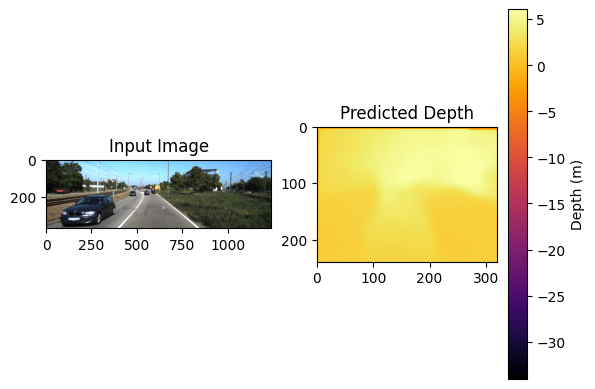

In [13]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread("/kaggle/input/delete1/del.png"), cv2.COLOR_BGR2RGB))
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(depth_map, cmap="inferno")
plt.colorbar(label="Depth (m)")
plt.title("Predicted Depth")
plt.show()
